In [2]:
import sklearn as skl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.set_cmap('gray')
from sklearn.model_selection import KFold, cross_val_score, train_test_split

catsAndDogs = pd.read_csv('./CATSnDOGS.csv')
labels = np.ravel(pd.read_csv("./Labels.csv"))

<Figure size 640x480 with 0 Axes>

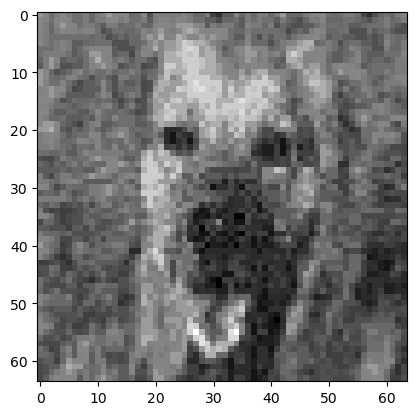

In [3]:
animal = catsAndDogs.loc[6]                   ## Retrieve animal at row
animal = animal.values.reshape((64,64)).T     ## Reshape to 64x64 and transpose to get correct orientation

plt.imshow(animal)
X_train, X_test, y_train, y_test = train_test_split(catsAndDogs, labels, test_size=0.2, random_state=1234567)


In [4]:
## Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score


estimator_range = range(10, 101, 10)

cv_scores = []

for n_estimators in estimator_range:
    clf_rf = RandomForestClassifier(n_estimators=n_estimators,random_state=1234567)
    scores = cross_val_score(clf_rf, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
optimal_n = estimator_range[cv_scores.index(max(cv_scores))]
# Create Random Forest classifier and fit the model
clf_rf = RandomForestClassifier(n_estimators=optimal_n,random_state=1234567) ## Tuneable parameters. Cross validation?
clf_rf.fit(X_train, y_train)

# Predict test set and calculate accuracy
y_pred_rf = clf_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Optimal n:",optimal_n)
print("Random Forest Classifier Accuracy:", accuracy_rf)

Optimal n: 70
Random Forest Classifier Accuracy: 0.9


In [5]:
## KNN Classifier (Code straight up ripped from last project task). Takes about 8s to run on my machine.


from sklearn.neighbors import KNeighborsClassifier

def knnClassification():

  # Define k-fold cross validation object
  k_values = list(range(1, 20))
  num_folds = 10
  kf = KFold(n_splits=num_folds, shuffle=True)
  mean_scores = [] # Will contain the mean cross validation scores for each k value


  # Loop over k values to test
  for k in k_values:
      # Create kNN classifier with k neighbors
      knn = KNeighborsClassifier(n_neighbors=k)
      
      # Use cross_val_score to perform k-fold cross validation and calculate mean accuracy
      scores = cross_val_score(knn, X_train, y_train, cv=kf, scoring='accuracy')
      mean_scores.append(np.mean(scores))

  best_k = k_values[np.argmax(mean_scores)]
  print(f"Best k value: {best_k}")


  # Evaluate the classifier on the test set
  knn = KNeighborsClassifier(n_neighbors=best_k)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)




  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy: ", accuracy)

  # TSNE plot
  #visualize(X_test,color=y_pred,title=f"KNN, frac mislabelled = {fraction}")
  return accuracy

accuracy = knnClassification()



Best k value: 16
Accuracy:  0.725


In [6]:
## LDA with single Value Decomposition. Otherwise straight ripped from last task as well :)


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

def LDAClassification():
  clf = LDA()
  clf.fit(X_train, y_train)

  y_pred = clf.predict(X_test)

  # Save variable for plot
  #visualize(X_test,color=y_pred,title=f"LDA, frac mislabelled = {fraction}")
  accuracy = accuracy_score(y_test, y_pred)
  print("Test Accuracy:", accuracy)

  return accuracy

LDAClassification()

Test Accuracy: 0.875


0.875

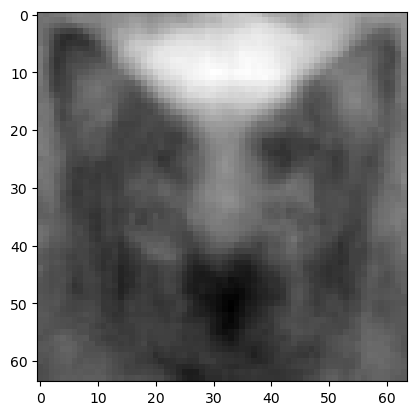

In [36]:
## Single Value Decomposition
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=2)            # Create matrix of 20 components

datasetTSVD = tsvd.fit_transform(catsAndDogs)   # Fit data to said 20 components
datasetTSVD_reconstructed = tsvd.inverse_transform(datasetTSVD) # Invert transform to original dimensions

testVisualisation = np.reshape(datasetTSVD_reconstructed[6],(64,64)).T
plt.imshow(testVisualisation)


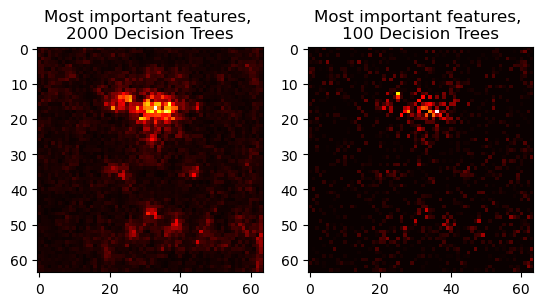

In [17]:
## Random Forest Feature Importance
forest = RandomForestClassifier(n_estimators=2000,random_state=1234567)
forest.fit(catsAndDogs,labels)

featureImportances = forest.feature_importances_
weight_vector = featureImportances.copy()
featureImportances = np.reshape(featureImportances,(64,64)).T

plt.subplot(1,2,1)
plt.title("Most important features, \n2000 Decision Trees")
plt.imshow(featureImportances, cmap="hot")

## Once again for a lower set of n_estimators
forest = RandomForestClassifier(n_estimators=100,random_state=1234567)
forest.fit(catsAndDogs,labels)

featureImportances = forest.feature_importances_
featureImportances = np.reshape(featureImportances,(64,64)).T

plt.subplot(1,2,2)
plt.title("Most important features, \n100 Decision Trees")
plt.imshow(featureImportances,cmap="hot")


### Theme 2a ###

Pollute random fraction of the pixels of a random fraction of the images

NaN in original data: 0
NaN in polluted data: 19


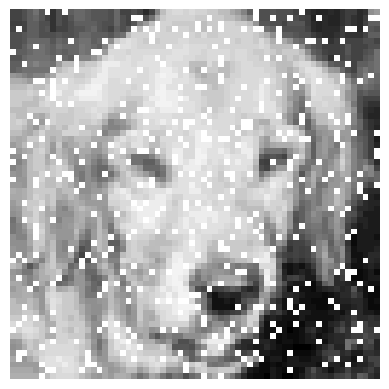

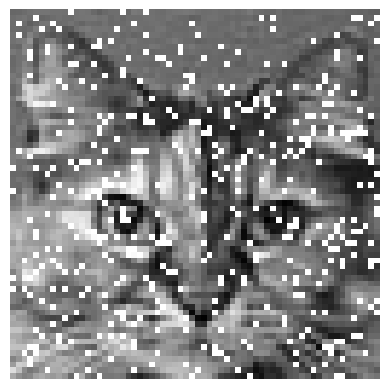

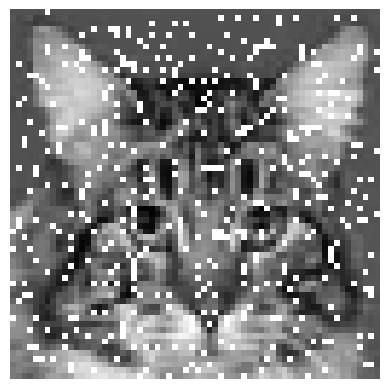

In [37]:
image_fraction = 0.1
pixel_fraction = 0.1

random_images = np.random.choice(catsAndDogs.shape[0], int(image_fraction*catsAndDogs.shape[0]), replace=False)

polluted_images = catsAndDogs.copy()

for i in random_images:
    im = catsAndDogs.loc[i]
    
    random_pixels = np.random.choice(4096, int(pixel_fraction*4096), replace=False) 
    
    im[random_pixels] = np.nan
    polluted_images.loc[i] = im

# Verify number of rows with NaN values
print('NaN in original data:', catsAndDogs.isnull().any(axis=1).sum())
print('NaN in polluted data:', polluted_images.isnull().any(axis=1).sum())

random_plot_images = np.random.choice(random_images, 3, replace=False)

for i in random_plot_images: # Plot some of the polluted images
    animal = polluted_images.loc[i]                         ## Retrieve animal at row
    animal = animal.values.reshape((64,64)).T               ## Reshape to 64x64 and transpose to get correct orientation

    plt.imshow(animal)
    plt.axis('off')
    plt.show()


Removing images with missing pixels

In [38]:
# Remove rows with NaN values
print('Images before pruning:', polluted_images.shape[0])
X_train_dropna = polluted_images.dropna(axis='rows')
print('Images after pruning:', X_train_dropna.shape[0])

## Do classification


Images before pruning: 198
Images after pruning: 179


Imputation

In [43]:
# Define function to compare resulting imputed image to original and polluted
def evaluate_imputation(image_indices):
    for i in image_indices:
        original = catsAndDogs.loc[i].values.reshape((64,64)).T
        polluted = polluted_images.loc[i].values.reshape((64,64)).T
        imputed = X_train_mean_imputed[i].reshape((64,64)).T
        
        f, ax = plt.subplots(1,3, figsize=(12,12))
        ax[0].imshow(polluted)
        ax[0].set_title('Polluted')
        ax[0].axis('off')
        
        ax[1].imshow(imputed)
        ax[1].set_title('Imputed')
        ax[1].axis('off')

        ax[2].imshow(original)
        ax[2].set_title('Original')
        ax[2].axis('off')
        plt.show()

Univariate imputation

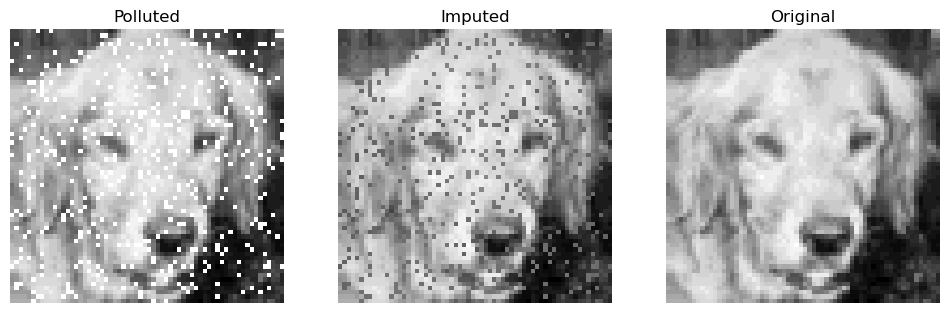

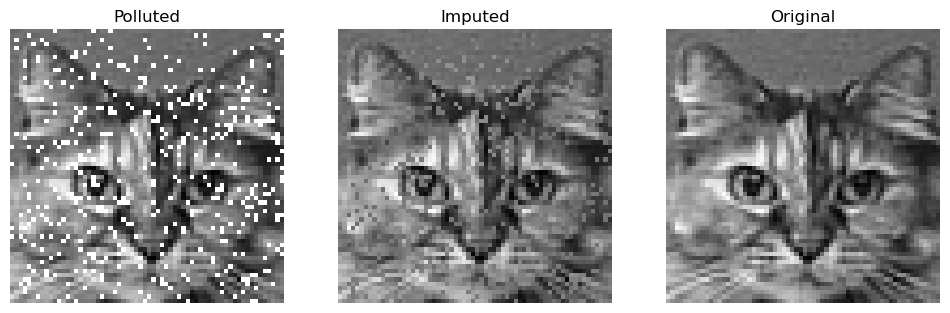

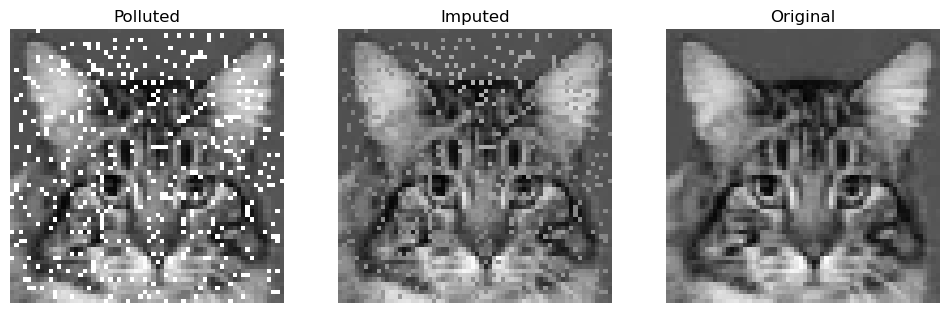

In [40]:
# Cleaning the data with different types of imputation 
from sklearn.impute import SimpleImputer # univariate imputation

# impute based on mean
mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_mean_imputed = mean_imputer.fit_transform(polluted_images)

# plot some of the imputed images
evaluate_imputation(random_plot_images)

Nearest neighbor imputation

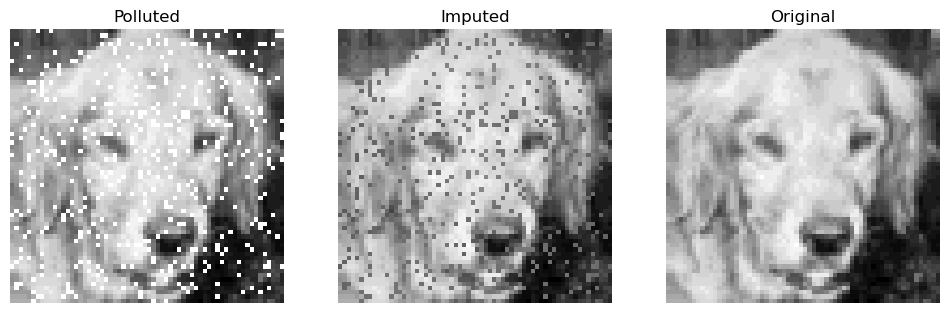

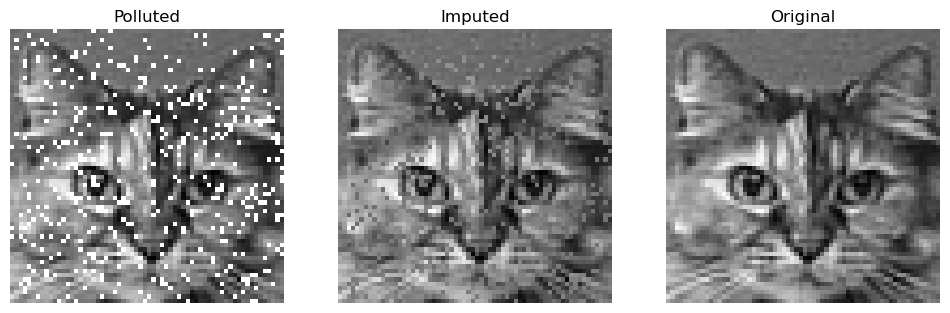

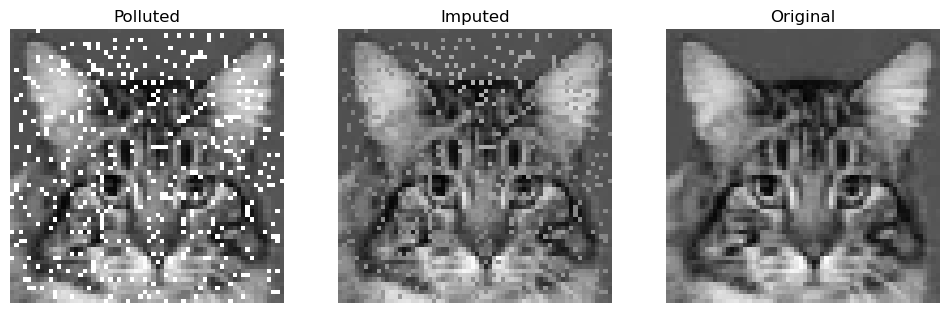

In [41]:
from sklearn.impute import KNNImputer
# Cleaning the data with KNN imputation
kNN_imputer = KNNImputer(n_neighbors=2, weights="uniform")
X_train_KNN_imputed = kNN_imputer.fit_transform(polluted_images)

# plot some of the imputed images
evaluate_imputation(random_plot_images)

Remove a random fraction of the significant pixels for a random subset of the images

NaN in original data: 0
NaN in polluted data: 19


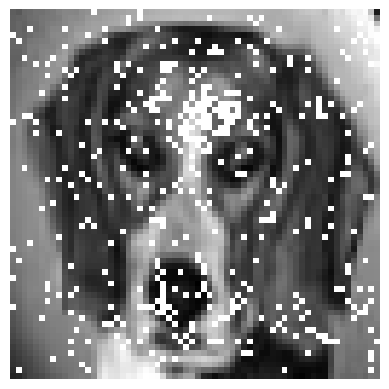

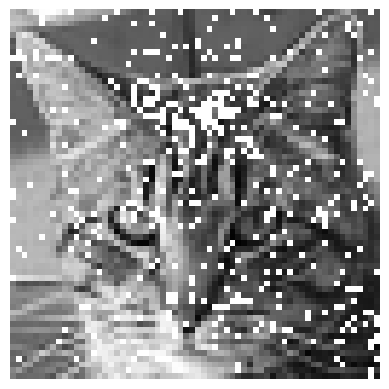

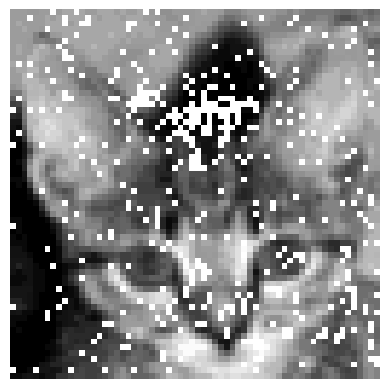

In [42]:
image_fraction = 0.1
pixel_fraction = 0.1

polluted_images = catsAndDogs.copy()

for i in random_images:
    im = catsAndDogs.loc[i]
    
    random_pixels = np.random.choice(4096, int(pixel_fraction*4096), replace=False, p = weight_vector) # 2000 estimators
    
    im[random_pixels] = np.nan
    polluted_images.loc[i] = im

# Verify number of rows with NaN values
print('NaN in original data:', catsAndDogs.isnull().any(axis=1).sum())
print('NaN in polluted data:', polluted_images.isnull().any(axis=1).sum())

random_plot_images = np.random.choice(random_images, 3, replace=False)

for i in random_plot_images: # Plot some of the polluted images
    animal = polluted_images.loc[i]                         ## Retrieve animal at row
    animal = animal.values.reshape((64,64)).T               ## Reshape to 64x64 and transpose to get correct orientation

    plt.imshow(animal)
    plt.axis('off')
    plt.show()